In [1]:
import numpy as np

import time

from scipy.stats import norm, multivariate_normal

from emcee.autocorr import integrated_time

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from corner import corner

# Case Study

In this notebook I apply the three main sampling algorithms we have covered so far (Metropolis-Hastings, Gibbs, and Hamiltonian Monte-Carlo) to a simple toy problem.

All of the sampling algorithms are simply coded "from scratch" in this notebook (using only basic `numpy` and `scipy` functions). 
This is not what you should do if you are interested in performance, there are many packages available. However, our focus here is instead on understanding the algorithms themselves.

Additionally, I use function for estimating the integrated autocorrelation time from the `emcee` package. 
So you should be able to run this notebook for yourself after just installing this single lightweight package.

In [ ]:
#!pip install emcee

# Toy Problem: target distribution

Let $P$ be the multivariate Gaussian distribution $\mathcal{N}(\mu,\Sigma)$ with mean $\mu=(0,0)$ and covariance matrix $((1,\beta),(\beta,1))$, with $\beta=0.99$. The PDF is

$$  P(x,y) \propto \exp\left(\frac{-\left[x^2+y^2 - 2\beta x y\right]}{2[\beta^2-1]}\right) $$

In [2]:
def target_logPDF(x, y, beta=0.99):
    return -0.5*(x**2+y**2-2*beta*x*y)/(1-beta**2)

# Gibbs

The Gibbs algorithm requires the 1-dimensional conditional distributions.
Because the target distribution is symmetric in $x$ and $y$ these are both identical and are $x|y\sim\mathcal{N}(2\beta y, 1)$ $y|x\sim\mathcal{N}(2\beta x, 1)$.

In [3]:
def sample_target_cond(y, beta=0.99, size=None):
    return norm(beta*y, np.sqrt(1-beta**2)).rvs(size)

We initialise the chain at the origin, $(x_0,y_0)=(0,0)$, evolve the Markov chain for $n=10^5$ iterations using the Gibbs sampling algorithm.

In [4]:
num_iter = 100000

chain_Gibbs = np.zeros((num_iter, 2))

time_start = time.time()

for i in range(num_iter-1):
    
    # choose parameter to update
    k = np.random.choice([0,1]) 
    
    # current position
    current_x, current_y = chain_Gibbs[i] 

    # new position
    if k==0:
        new_x = sample_target_cond(current_y)
        new_y = current_y
    elif k==1:
        new_x = current_x
        new_y = sample_target_cond(current_x)
    
    # store new position in chain
    chain_Gibbs[i+1] = [new_x, new_y]
    
time_end = time.time()

print("Cost per iteration = {:.3f}ms".format(1000*(time_end-time_start)/num_iter))

Cost per iteration = 0.177ms


Let's look at part of the chain. 

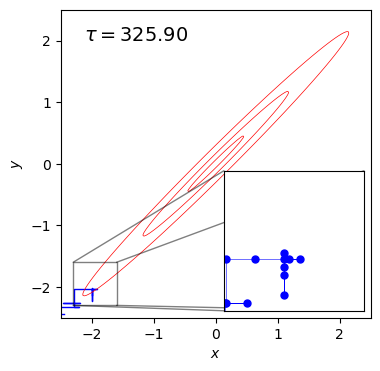

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))

start, steps = np.argmin(np.abs(chain_Gibbs[:,0]+2.)), 20
ax.plot(chain_Gibbs[start:start+steps,0], chain_Gibbs[start:start+steps,1], 
        '-', color='b', lw=1)

x = np.arange(-4.0, 4.0, 0.02)
y = np.arange(-4.0, 4.0, 0.02)
X, Y = np.meshgrid(x, y)
Z = np.exp(target_logPDF(X, Y))
ax.contour(X, Y, Z, levels=[0.1, 0.5, 0.9], 
           colors='r', linewidths=0.5)

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

axins = inset_axes(ax, width=1.4, height=1.4, loc=4)
axins.plot(chain_Gibbs[start:start+steps,0], chain_Gibbs[start:start+steps,1], 
           '-', color='b', lw=0.4)
axins.plot(chain_Gibbs[start:start+steps,0], chain_Gibbs[start:start+steps,1], 
           'o', color='b', ms=5)
axins.set_xlim(-2.3, -1.6)
axins.set_ylim(-2.3, -1.6)
axins.set_xticks([])
axins.set_yticks([])
rectpatch, connects = ax.indicate_inset_zoom(axins, edgecolor="black")
for c in connects:
    c.set_visible(True)
    
tau = np.max([integrated_time(chain_Gibbs[:,k]) for k in [0,1]])
ax.text(-2.12, 2, r"$\tau={:.2f}$".format(tau), size=14)

plt.show()

# Metropolis Hastings

$$
Q_\mathrm{Small} = \mathcal{N}\left(\begin{pmatrix}0\\0\end{pmatrix},\begin{pmatrix}0.1&0\\0&0.1\end{pmatrix}\right) $$

$$ Q_\mathrm{Large} = \mathcal{N}\left(\begin{pmatrix}0\\0\end{pmatrix},\begin{pmatrix}1&0\\0&1\end{pmatrix}\right) $$

$$ Q_\mathrm{Corr} = \mathcal{N}\left(\begin{pmatrix}0\\0\end{pmatrix},\begin{pmatrix}1&\beta\\ \beta&1\end{pmatrix}\right) $$

In [6]:
cov_Qsmall = np.array([[0.05,0.],[0.,0.05]])

num_iter, num_accept = 100000, 0

chain_Qsmall = np.zeros((num_iter, 2))

time_start = time.time()

for i in range(num_iter-1):

    # current position
    x_current = chain_Qsmall[i]
    
    # proposed position
    x_proposed = multivariate_normal(x_current, cov_Qsmall).rvs()
    
    # acceptance ratio
    log_a = target_logPDF(*x_proposed) - target_logPDF(*x_current)
                      
    # new position
    u = np.random.uniform()
    if np.log(u)<log_a:
        x_new = x_proposed
        num_accept += 1
    else:
        x_new = x_current
    
    # store new position in chain
    chain_Qsmall[i+1] = x_new
    
time_end = time.time()

print("Cost per iteration = {:.3f}ms".format(1000*(time_end-time_start)/num_iter))
    
# acceptance fraction
g_Qsmall = num_accept/num_iter

Cost per iteration = 0.062ms


In [7]:
cov_Qlarge = np.array([[1.5,0.],[0.,1.5]])

num_iter, num_accept = 100000, 0

chain_Qlarge = np.zeros((num_iter, 2))

for i in range(num_iter-1):

    # current position
    x_current = chain_Qlarge[i]
    
    # proposed position
    x_proposed = multivariate_normal(x_current, cov_Qlarge).rvs()
    
    # acceptance ratio
    log_a = target_logPDF(*x_proposed) - target_logPDF(*x_current)
                      
    # new position
    u = np.random.uniform()
    if np.log(u)<log_a:
        x_new = x_proposed
        num_accept += 1
    else:
        x_new = x_current
    
    # store new position in chain
    chain_Qlarge[i+1] = x_new
    
# acceptance fraction
g_Qlarge = num_accept/num_iter

In [8]:
cov_Qcorr = np.array([[1.,0.99],[0.99,1.]])

num_iter, num_accept = 100000, 0

chain_Qcorr = np.zeros((num_iter, 2))

for i in range(num_iter-1):

    # current position
    x_current = chain_Qcorr[i]
    
    # proposed position
    x_proposed = multivariate_normal(x_current, cov_Qcorr).rvs()
    
    # acceptance ratio
    log_a = target_logPDF(*x_proposed) - target_logPDF(*x_current)
                      
    # new position
    u = np.random.uniform()
    if np.log(u)<log_a:
        x_new = x_proposed
        num_accept += 1
    else:
        x_new = x_current
    
    # store new position in chain
    chain_Qcorr[i+1] = x_new
    
# acceptance fraction
g_Qcorr = num_accept/num_iter

In [9]:
tau_Qsmall = np.max([integrated_time(chain_Qsmall[:,k]) for k in [0,1]])
tau_Qlarge = np.max([integrated_time(chain_Qlarge[:,k]) for k in [0,1]])
tau_Qcorr = np.max([integrated_time(chain_Qcorr[:,k]) for k in [0,1]])

Look at chains.

/var/folders/qj/mhy_bkdx1n7dy8knwlxg3fqw0000gn/T/ipykernel_94483/3113603786.py:53: RuntimeWarning: invalid value encountered in sqrt
  (2*np.sqrt(1 - x**2))/np.sqrt(1 - beta**2)))/2.
/var/folders/qj/mhy_bkdx1n7dy8knwlxg3fqw0000gn/T/ipykernel_94483/3113603786.py:55: RuntimeWarning: invalid value encountered in sqrt
  (2*np.sqrt(1 - x**2))/np.sqrt(1 - beta**2)))/2.


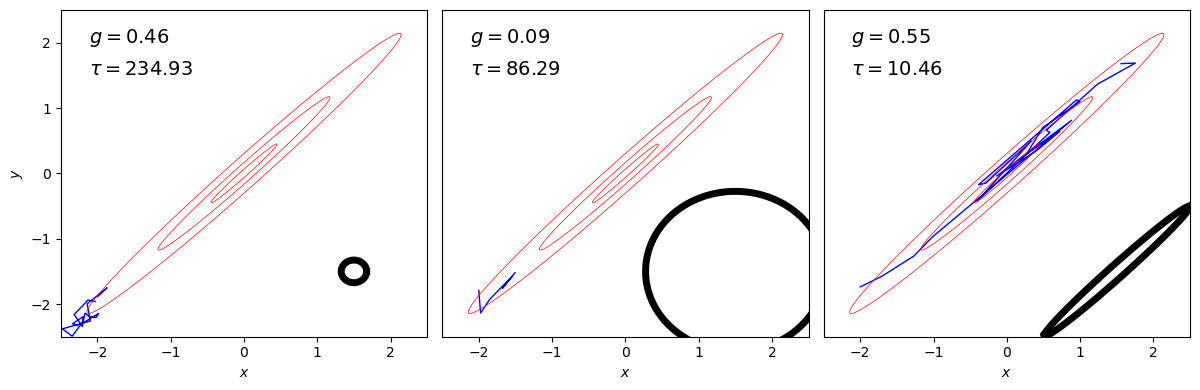

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12.1, 4))

start, steps = np.argmin(np.abs(chain_Qsmall[:,0]+2.)), 40
ax[0].plot(chain_Qsmall[start:start+steps,0], chain_Qsmall[start:start+steps,1], 
        '-', color='b', lw=1)

start, steps = np.argmin(np.abs(chain_Qlarge[:,0]+2.)), 40
ax[1].plot(chain_Qlarge[start:start+steps,0], chain_Qlarge[start:start+steps,1], 
        '-', color='b', lw=1)

start, steps = np.argmin(np.abs(chain_Qcorr[:,0]+2.)), 40
ax[2].plot(chain_Qcorr[start:start+steps,0], chain_Qcorr[start:start+steps,1], 
        '-', color='b', lw=1)

ax[0].text(-2.12, 2, r"$g={:.2f}$".format(g_Qsmall), size=14)
ax[1].text(-2.12, 2, r"$g={:.2f}$".format(g_Qlarge), size=14)
ax[2].text(-2.12, 2, r"$g={:.2f}$".format(g_Qcorr), size=14)

ax[0].text(-2.12, 1.5, r"$\tau={:.2f}$".format(tau_Qsmall), size=14)
ax[1].text(-2.12, 1.5, r"$\tau={:.2f}$".format(tau_Qlarge), size=14)
ax[2].text(-2.12, 1.5, r"$\tau={:.2f}$".format(tau_Qcorr), size=14)

x = np.arange(-4.0, 4.0, 0.02)
y = np.arange(-4.0, 4.0, 0.02)
X, Y = np.meshgrid(x, y)
Z = np.exp(target_logPDF(X, Y))
for k in range(3):
    ax[k].contour(X, Y, Z, levels=[0.1, 0.5, 0.9], 
           colors='r', linewidths=0.5)

for k in range(3):
    ax[k].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$y$")

for k in range(3):
    ax[k].set_xlim(-2.5, 2.5)
    ax[k].set_ylim(-2.5, 2.5)

ax[1].set_yticks([])
ax[2].set_yticks([])
fig.subplots_adjust(wspace=0.04)

for k in range(3):
    ax[k].set_xlim(-2.5, 2.5)
    ax[k].set_ylim(-2.5, 2.5)
    
phi = np.linspace(0, 2*np.pi, 100)
ax[0].plot(1.5+np.sqrt(0.03)*np.cos(phi), -1.5+np.sqrt(0.03)*np.sin(phi), 'k-', lw=5)
ax[1].plot(1.5+np.sqrt(1.5)*np.cos(phi), -1.5+np.sqrt(1.5)*np.sin(phi), 'k-', lw=5)
x = np.linspace(-2.5, 2.5, 100)
beta=0.99
top = ((1 - beta**2)*((-2*x*beta)/(beta**2-1) - 
       (2*np.sqrt(1 - x**2))/np.sqrt(1 - beta**2)))/2.
bottom = ((1 - beta**2)*((-2*x*beta)/(beta**2-1) + 
       (2*np.sqrt(1 - x**2))/np.sqrt(1 - beta**2)))/2.
ax[2].plot(1.5+x, -1.5+top, 'k-', lw=5)
ax[2].plot(1.5+x, -1.5+bottom, 'k-', lw=5)

plt.tight_layout()
plt.show()

# Hamiltonian Monte Carlo

HMC needs derivatives.

We also need a mass matrix $M$, which defines the momentum distribution, $Q$.

In [11]:
def potential_energy(x, y, beta=0.99):
    return -target_logPDF(x, y, beta=beta)

def grad_potential_energy(x, y, beta=0.99):
    return np.array([x-beta*y, y-beta*x]) / (1-beta**2)

mass_matrix = np.eye(2)
Q = multivariate_normal(np.zeros(2), mass_matrix)

def kinetic_energy(x, y):
    return -Q.logpdf([x, y])

In [12]:
def leapfrog_step(x, p, delta_t):
    P = p - 0.5*delta_t*grad_potential_energy(*x)
    X = x + delta_t*P
    P = P - 0.5*delta_t*grad_potential_energy(*X)
    return X, P

def numerical_integration(x_start, p_start, L, return_trajectory=False):
    traj = np.zeros((L+1,2))
    
    x, p = x_start.copy(), p_start.copy()
    traj[0] = x
    for l in range(L):
        x, p = leapfrog_step(x, p, delta_t)
        traj[l+1] = x
        
    if return_trajectory:
        return x, p, traj
    else:
        return x, p     

We initialise the chain at the origin, $(x_0,y_0)=(0,0)$, evolve the Markov chain for $n=10^5$ iterations using the HMC sampling algorithm.

In [13]:
num_iter, num_accept = 100000, 0

L = 5

delta_t = 5.0e-2

chain_Lshort = np.zeros((num_iter, 2))
chain_Lshort[0] = [-2, -2]

time_start = time.time()

for i in range(num_iter-1):
    
    # current position
    x_current = chain_Lshort[i]
    
    # draw new momentum
    p_current = Q.rvs()
    
    # numerical integration
    if i==3:
        x, p, traj_Lshort = numerical_integration(x_current, p_current, L, return_trajectory=True)
    else:
        x, p = numerical_integration(x_current, p_current, L)
    
    # acceptance ratio
    log_a = potential_energy(*x_current) + kinetic_energy(*p_current)
    log_a -= potential_energy(*x) + kinetic_energy(*p)
                      
    # new position
    u = np.random.uniform()
    if np.log(u)<log_a:
        x_new = x
        num_accept += 1
    else:
        x_new = x_current
    
    # store new position in chain
    chain_Lshort[i+1] = x_new
    
time_end = time.time()

print("Cost per iteration = {:.3f}ms".format(1000*(time_end-time_start)/num_iter))
    
# acceptance fraction
g_Lshort = num_accept/num_iter

Cost per iteration = 0.063ms


In [14]:
num_iter, num_accept = 100000, 0

L = 50

delta_t = 5.0e-2

chain_Lmedium = np.zeros((num_iter, 2))
chain_Lmedium[0] = [-2, -2]

time_start = time.time()

for i in range(num_iter-1):
    
    # current position
    x_current = chain_Lmedium[i]
    
    # draw new momentum
    p_current = Q.rvs()
    
    # numerical integration
    if i==0:
        x, p, traj_Lmedium = numerical_integration(x_current, p_current, L, return_trajectory=True)
    else:
        x, p = numerical_integration(x_current, p_current, L)
    
    # acceptance ratio
    log_a = potential_energy(*x_current) + kinetic_energy(*p_current)
    log_a -= potential_energy(*x) + kinetic_energy(*p)
                      
    # new position
    u = np.random.uniform()
    if np.log(u)<log_a:
        x_new = x
        num_accept += 1
    else:
        x_new = x_current
    
    # store new position in chain
    chain_Lmedium[i+1] = x_new
    
time_end = time.time()

print("Cost per iteration = {:.3f}ms".format(1000*(time_end-time_start)/num_iter))
    
# acceptance fraction
g_Lmedium = num_accept/num_iter

Cost per iteration = 0.248ms


In [15]:
np.max([integrated_time(chain_Lmedium[:,k]) for k in [0,1]])

0.7213835087699989

In [16]:
num_iter, num_accept = 100000, 0

L = 500

delta_t = 5.0e-2

chain_Llong = np.zeros((num_iter, 2))
chain_Llong[0] = [-2, -2]

time_start = time.time()

for i in range(num_iter-1):
    
    # current position
    x_current = chain_Llong[i]
    
    # draw new momentum
    p_current = Q.rvs()
    
    # numerical integration
    if i==0:
        x, p, traj_Llong = numerical_integration(x_current, p_current, L, return_trajectory=True)
    else:
        x, p = numerical_integration(x_current, p_current, L)
        
    # acceptance ratio
    log_a = potential_energy(*x_current) + kinetic_energy(*p_current)
    log_a -= potential_energy(*x) + kinetic_energy(*p)
                      
    # new position
    u = np.random.uniform()
    if np.log(u)<log_a:
        x_new = x
        num_accept += 1
    else:
        x_new = x_current
    
    # store new position in chain
    chain_Llong[i+1] = x_new

time_end = time.time()

print("Cost per iteration = {:.3f}ms".format(1000*(time_end-time_start)/num_iter))
    
# acceptance fraction
g_Llong = num_accept/num_iter

Cost per iteration = 2.064ms


In [17]:
tau_Lshort = np.max([integrated_time(chain_Lshort[:,k]) for k in [0,1]])
tau_Lmedium = np.max([integrated_time(chain_Lmedium[:,k]) for k in [0,1]])
tau_Llong = np.max([integrated_time(chain_Llong[:,k]) for k in [0,1]])

/var/folders/qj/mhy_bkdx1n7dy8knwlxg3fqw0000gn/T/ipykernel_94483/296616174.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


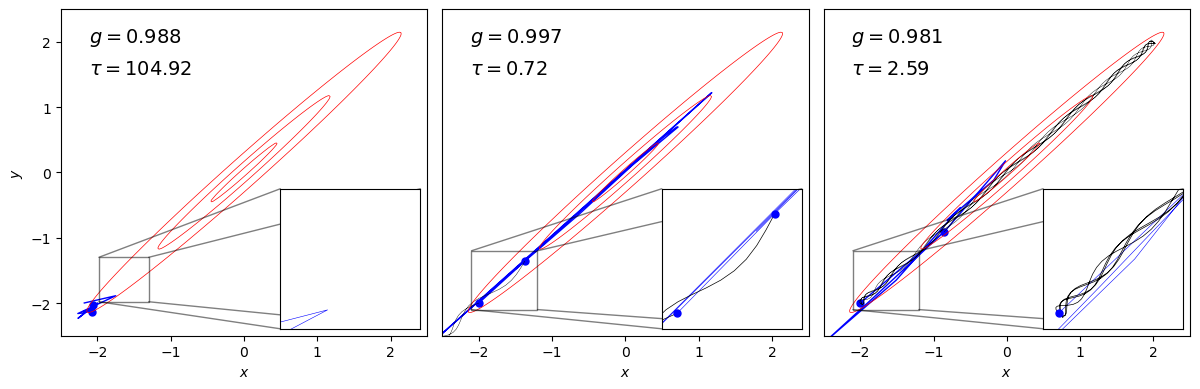

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12.1, 4))

start, steps = 0, 10
ax[0].plot(chain_Lshort[start:start+steps,0], chain_Lshort[start:start+steps,1], 
        '-', color='b', lw=1)
ax[0].plot(chain_Lshort[3:3+2,0], chain_Lshort[3:3+2,1], 
           'o', color='b', ms=5)

ax[1].plot(chain_Lmedium[start:start+steps,0], chain_Lmedium[start:start+steps,1], 
        '-', color='b', lw=1)
ax[1].plot(chain_Lmedium[start:start+2,0], chain_Lmedium[start:start+2,1], 
           'o', color='b', ms=5)
ax[1].plot(traj_Lmedium[:,0], traj_Lmedium[:,1], 
           '-', color='k', lw=0.3)



ax[2].plot(chain_Llong[start:start+steps,0], chain_Llong[start:start+steps,1], 
        '-', color='b', lw=1)

ax[2].plot(chain_Llong[start:start+2,0], chain_Llong[start:start+2,1], 
           'o', color='b', ms=5)

ax[2].plot(traj_Llong[:,0], traj_Llong[:,1], 
           '-', color='k', lw=0.3)


x = np.arange(-4.0, 4.0, 0.02)
y = np.arange(-4.0, 4.0, 0.02)
X, Y = np.meshgrid(x, y)
Z = np.exp(target_logPDF(X, Y))
for k in range(3):
    ax[k].contour(X, Y, Z, levels=[0.1, 0.5, 0.9], 
           colors='r', linewidths=0.5)
    
ax[0].text(-2.12, 2, r"$g={:.3f}$".format(g_Lshort), size=14)
ax[1].text(-2.12, 2, r"$g={:.3f}$".format(g_Lmedium), size=14)
ax[2].text(-2.12, 2, r"$g={:.3f}$".format(g_Llong), size=14)

ax[0].text(-2.12, 1.5, r"$\tau={:.2f}$".format(tau_Lshort), size=14)
ax[1].text(-2.12, 1.5, r"$\tau={:.2f}$".format(tau_Lmedium), size=14)
ax[2].text(-2.12, 1.5, r"$\tau={:.2f}$".format(tau_Llong), size=14)

for k in range(3):
    ax[k].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$y$")

for k in range(3):
    ax[k].set_xlim(-2.5, 2.5)
    ax[k].set_ylim(-2.5, 2.5)

ax[1].set_yticks([])
ax[2].set_yticks([])
fig.subplots_adjust(wspace=0.04)
    
axins = inset_axes(ax[0], width=1.4, height=1.4, loc=4)
axins.plot(chain_Lshort[start:start+steps,0], chain_Lshort[start:start+steps,1], 
           '-', color='b', lw=0.4)
axins.plot(chain_Lshort[3:3+2,0], chain_Lshort[3:3+2,1], 
           'o', color='b', ms=5)
axins.plot(traj_Lshort[:,0], traj_Lshort[:,1], 
        '-', color='k', lw=2)
axins.set_xlim(-1.98, -1.3)
axins.set_ylim(-1.98, -1.3)
axins.set_xticks([])
axins.set_yticks([])
rectpatch, connects = ax[0].indicate_inset_zoom(axins, edgecolor="black")
for c in connects:
    c.set_visible(True)
    
axins2 = inset_axes(ax[2], width=1.4, height=1.4, loc=4)
axins2.plot(chain_Llong[start:start+steps,0], chain_Llong[start:start+steps,1], 
           '-', color='b', lw=0.4)
axins2.plot(traj_Llong[:,0], traj_Llong[:,1], 'k-', lw=0.5)
axins2.plot(chain_Llong[start:start+2,0], chain_Llong[start:start+2,1],
            'o', color='b', ms=5)
axins2.set_xlim(-2.1, -1.2)
axins2.set_ylim(-2.1, -1.2)
axins2.set_xticks([])
axins2.set_yticks([])
rectpatch, connects = ax[2].indicate_inset_zoom(axins2, edgecolor="black")
for c in connects:
    c.set_visible(True)
    
axins3 = inset_axes(ax[1], width=1.4, height=1.4, loc=4)
axins3.plot(chain_Lmedium[start:start+steps,0], chain_Lmedium[start:start+steps,1], 
           '-', color='b', lw=0.4)
axins3.plot(traj_Lmedium[:,0], traj_Lmedium[:,1], 'k-', lw=0.5)
axins3.plot(chain_Lmedium[start:start+2,0], chain_Lmedium[start:start+2,1],
            'o', color='b', ms=5)
axins3.set_xlim(-2.1, -1.2)
axins3.set_ylim(-2.1, -1.2)
axins3.set_xticks([])
axins3.set_yticks([])
rectpatch, connects = ax[1].indicate_inset_zoom(axins3, edgecolor="black")
for c in connects:
    c.set_visible(True)
        
plt.tight_layout()
plt.show()